In [26]:
# for data processing
import pandas as pd
import numpy as np

# package for calculation
import math

# packages for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# interpret training result
import seaborn as sns
from sklearn import metrics
# from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# saving accuracy and f1 score
import pickle

import os

%matplotlib inline




# import warnings
# warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
import random
random.seed(10)
np.random.seed(10)

In [2]:
selected_features = pd.read_csv('/content/drive/MyDrive/Binary_Win_Latest/Dataset/Features selected/CICDDoS2019_Binary_RFClassifier_30.csv').squeeze()
selected_features = selected_features[:20]

In [4]:
CICDDoS2019_binary = pd.read_csv('/content/drive/MyDrive/Binary_Win_Latest/Dataset/Encoded Dataset/CIC-DDoS2019_binary.csv')

# Create the 'columns' list using 'selected_features' and columns starting with 'Label_'
columns = selected_features.tolist() + [col for col in CICDDoS2019_binary.columns if col.startswith('Label_')]

# Use the 'columns' list to select specific columns from 'CICDDoS2019'
CICDDoS2019_binary = CICDDoS2019_binary[columns]


In [5]:
CICDDoS2019_binary.shape

(300000, 22)

In [6]:
target_columns = [col for col in CICDDoS2019_binary.columns if col.startswith('Label_')]

# Sample 10% of the data and reset the index
CICDDoS2019_sampled = CICDDoS2019_binary.sample(frac=0.25, random_state=42).reset_index(drop=True)

# Print class distribution for each target column
for column in target_columns:
    print(f'Class distribution for {column}:')
    print(CICDDoS2019_sampled[column].value_counts())
    print()

Class distribution for Label_benign:
0.0    37581
1.0    37419
Name: Label_benign, dtype: int64

Class distribution for Label_attack:
1.0    37581
0.0    37419
Name: Label_attack, dtype: int64



In [8]:
# Separate features and labels
DDoS2019_binary_X = CICDDoS2019_sampled.drop(CICDDoS2019_sampled.filter(regex='^Label_'), axis=1).copy()
DDoS2019_binary_y = CICDDoS2019_sampled[CICDDoS2019_sampled.filter(regex='^Label_').columns].copy()

# Split the dataset into training and testing sets
DDoS2019_binary_train_X, DDoS2019_binary_test_X, DDoS2019_binary_train_y, DDoS2019_binary_test_y = train_test_split(DDoS2019_binary_X, DDoS2019_binary_y, test_size=0.2)


In [9]:
scalar = StandardScaler()
# only fit the training data
DDoS2019_train_X_scaled = scalar.fit(DDoS2019_binary_train_X)

DDoS2019_train_X_scaled = scalar.transform(DDoS2019_binary_train_X)
DDoS2019_test_X_scaled = scalar.transform(DDoS2019_binary_test_X)

In [10]:
models = {
    'k-Nearest Neighbour': KNeighborsClassifier(algorithm='auto', n_neighbors=5, weights='distance', metric='manhattan'),
    'Random Forest': RandomForestClassifier(max_depth=30, min_samples_leaf=1e-05, min_samples_split=1e-05, n_estimators=200, n_jobs=-1,criterion='entropy'),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', alpha=1e-05, solver='adam', max_iter=500),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(12, 12, 12), activation='tanh', alpha=0.001, solver='adam', max_iter=1000),
    'XGBoost': xgb.XGBClassifier(n_estimators=400, colsample_bytree=0.9, learning_rate=0.3, max_depth=4, min_child_weight=1, subsample=0.9)

}


------------------------- k-Nearest Neighbour -------------------------
              precision    recall  f1-score   support

      benign     0.9989    0.9996    0.9993      7483
      attack     0.9996    0.9989    0.9993      7517

   micro avg     0.9993    0.9993    0.9993     15000
   macro avg     0.9993    0.9993    0.9993     15000
weighted avg     0.9993    0.9993    0.9993     15000
 samples avg     0.9993    0.9993    0.9993     15000


------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign     0.9995    1.0000    0.9997      7483
      attack     1.0000    0.9995    0.9997      7517

   micro avg     0.9997    0.9997    0.9997     15000
   macro avg     0.9997    0.9997    0.9997     15000
weighted avg     0.9997    0.9997    0.9997     15000
 samples avg     0.9997    0.9997    0.9997     15000


------------------------- Artificial Neural Network -------------------------
              precis

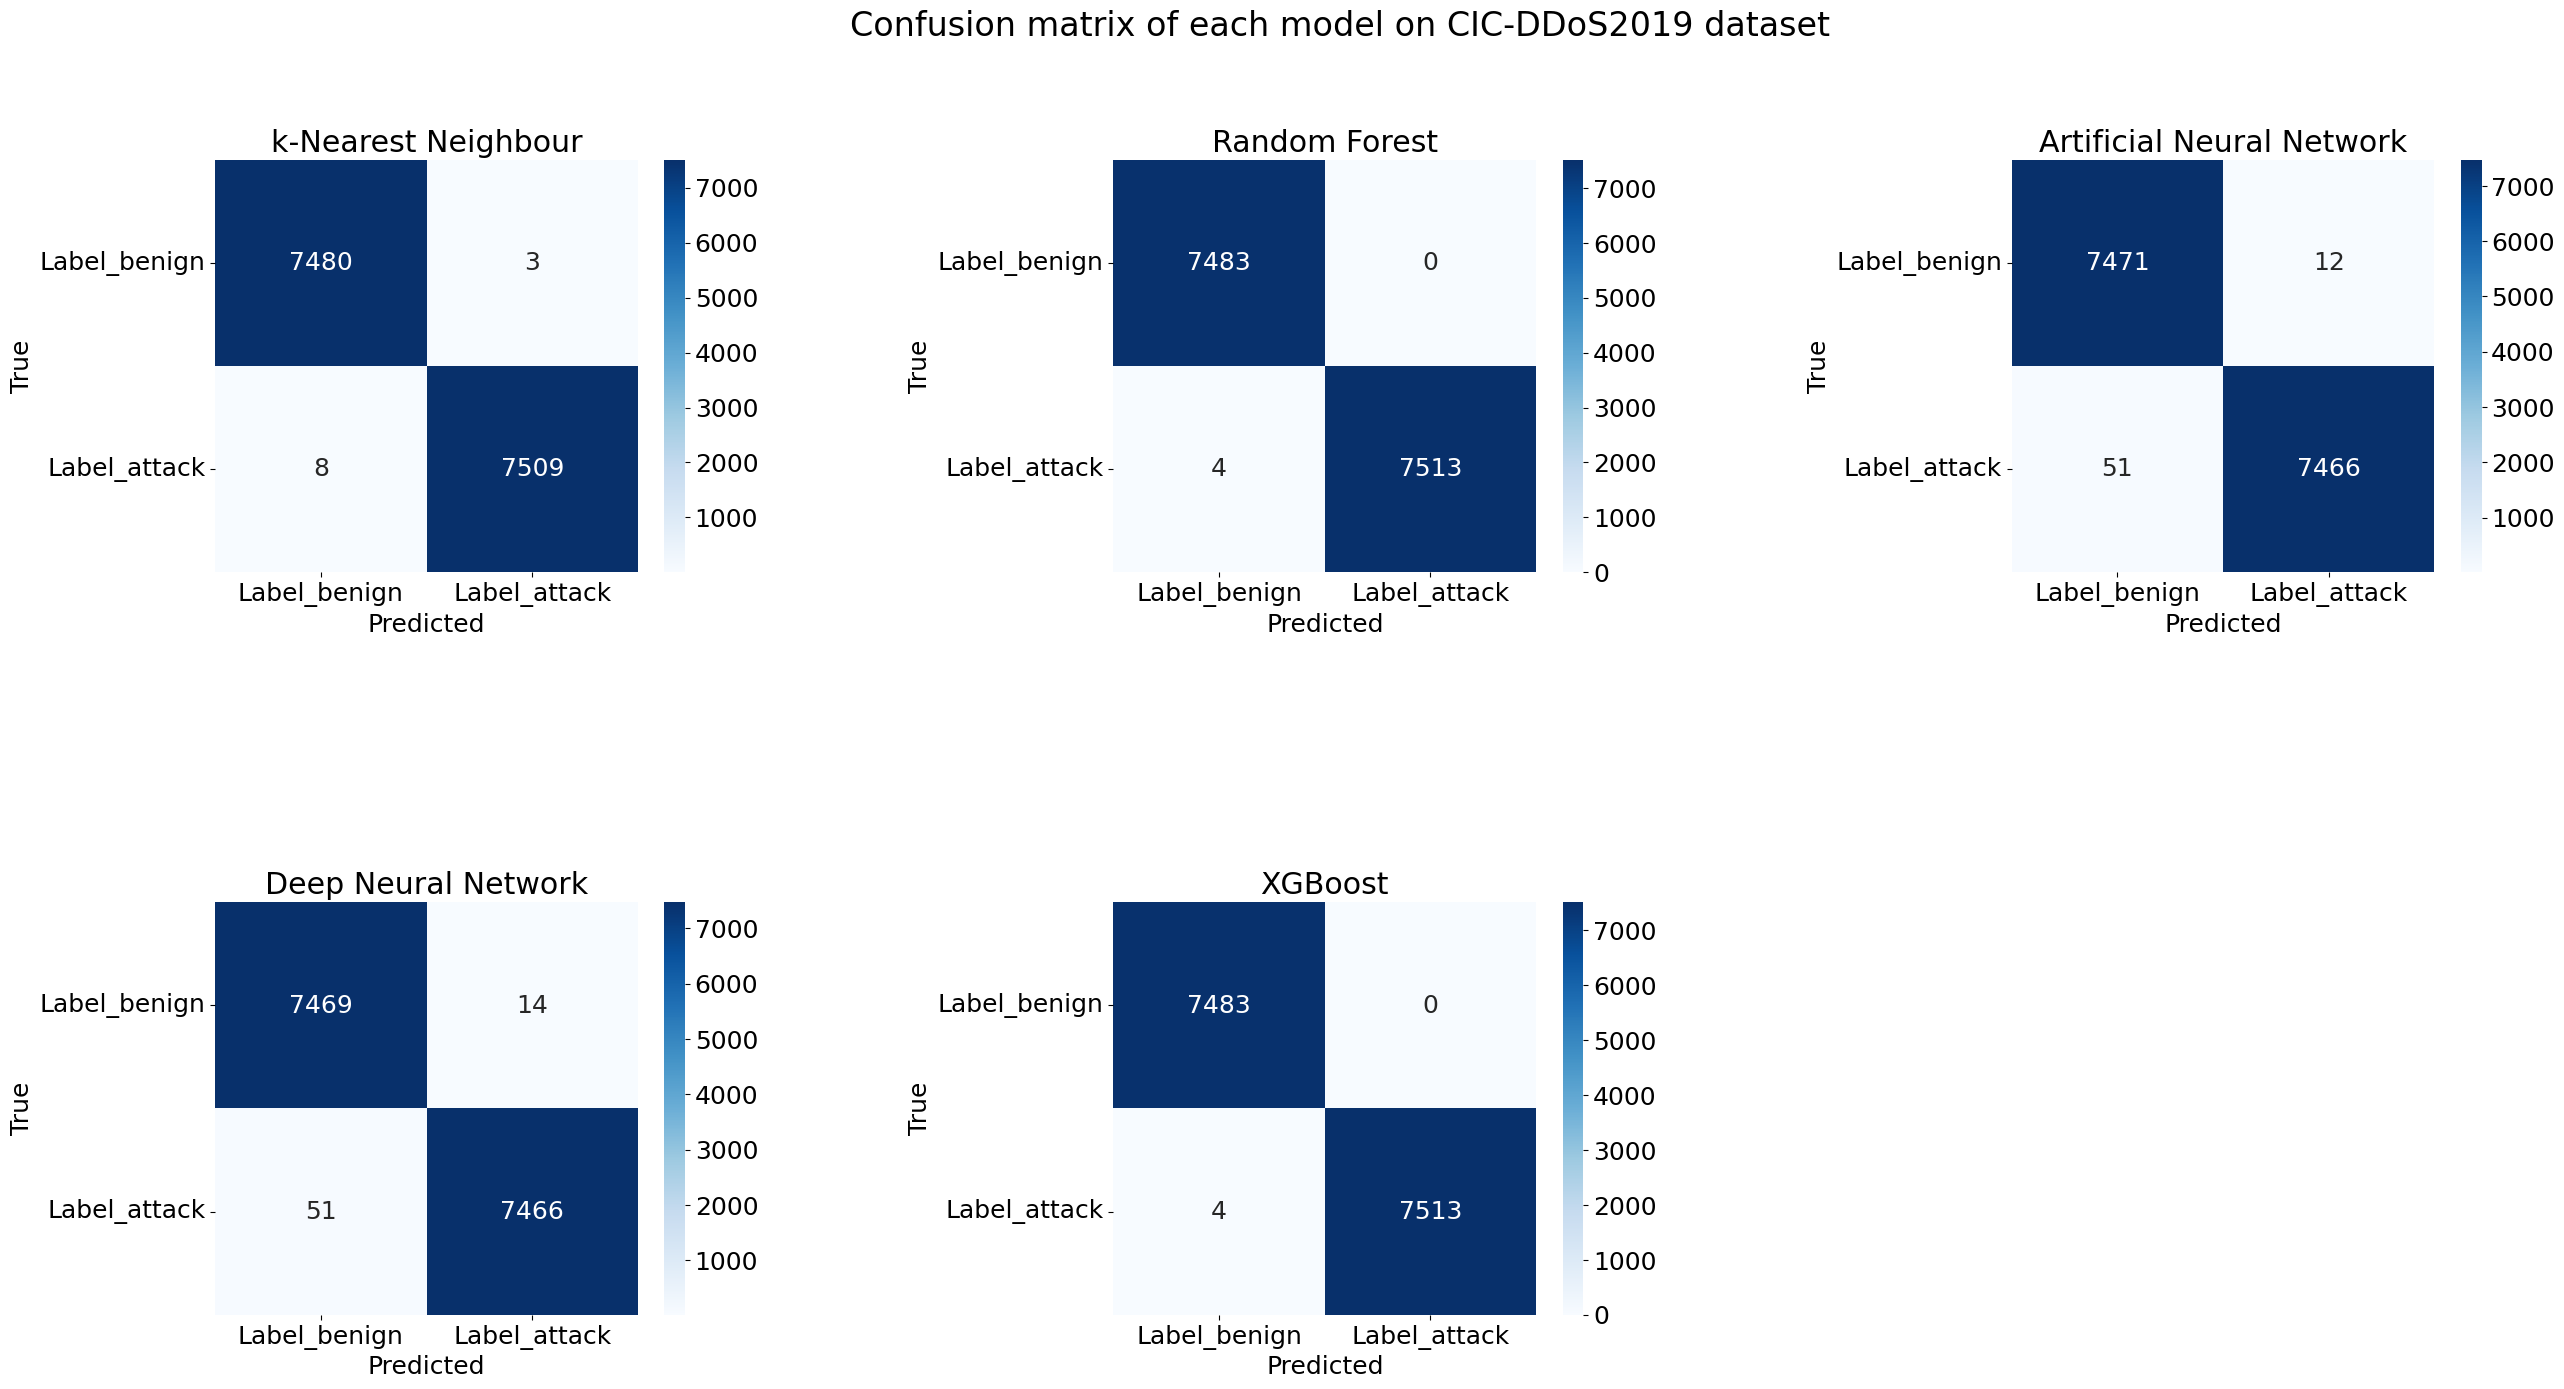

In [23]:
# Dictionary to store the reports, accuracy, and F1 score
classification_reports = {}
accuracy_scores = {}
f1_scores = {}

plt.rcParams.update({'font.size': 18})

# layout dimensions
num_models = len(models)
num_rows = 2
num_cols = int(np.ceil(num_models / num_rows))

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 15))
flatten_axes = axes.flatten()  # Flatten the axes array for easier indexing


for i, (model_name, model) in enumerate(models.items()):

    # Fit the model on the training data
    model.fit(DDoS2019_train_X_scaled, DDoS2019_binary_train_y)

    # Generate predictions for the test set
    y_pred = model.predict(DDoS2019_test_X_scaled)

    # Extract the target labels with "Label_" prefix
    target_columns = [col for col in DDoS2019_binary_test_y.columns if col.startswith("Label_")]
    target_names = [col.split("Label_")[1] for col in target_columns]

    # Compute the classification report
    report = classification_report(DDoS2019_binary_test_y[target_columns], y_pred, digits=4, target_names=target_names)

    # Save the classification report
    classification_reports[model_name] = report

    # Print the classification report
    print(f"{'-' * 25} {model_name} {'-' * 25}")
    print(report)
    print(f"Accuracy: {accuracy_scores[model_name]:.4f}")
    print(f"F1 Score: {f1_scores[model_name]:.4f}")
    print()

    # Compute the accuracy
    accuracy = accuracy_score(DDoS2019_binary_test_y[target_columns], y_pred)
    accuracy_scores[model_name] = accuracy

    # Compute the F1 score
    f1 = f1_score(DDoS2019_binary_test_y[target_columns], y_pred, average='weighted')
    f1_scores[model_name] = f1

    # Compute the confusion matrix
    cm = confusion_matrix(DDoS2019_binary_test_y[target_columns].values.argmax(axis=1), y_pred.argmax(axis=1))

    # Calculate the row and column index in the subplots grid
    row = i // num_cols
    col = i % num_cols

    # Create a figure and axis
    ax = flatten_axes[i]

    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

    # Set labels, title, and ticks
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name}')
    ax.xaxis.set_ticklabels(target_columns, rotation=0)
    ax.yaxis.set_ticklabels(target_columns, rotation=0)

# Remove empty subplots
for i in range(num_models, num_rows * num_cols):
    fig.delaxes(flatten_axes[i])

# Adjust the layout spacing
fig.subplots_adjust(hspace=0.8, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CIC-DDoS2019 dataset', fontsize=24)

# Save accuracy and F1 score as pickle file
with open('metrics.pkl', 'wb') as f:
    pickle.dump({'accuracy': accuracy_scores, 'f1_score': f1_scores}, f)

# Show the plot
plt.show()


In [ ]:
# Dictionary to store the reports, accuracy, and F1 score
classification_reports = {}
accuracy_scores = {}
f1_scores = {}

plt.rcParams.update({'font.size': 18})

# layout dimensions
num_models = len(models)
num_rows = 2
num_cols = int(np.ceil(num_models / num_rows))

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 15))
flatten_axes = axes.flatten()  # Flatten the axes array for easier indexing


for i, (model_name, model) in enumerate(models.items()):

    # Fit the model on the training data
    model.fit(DDoS2019_train_X_scaled, DDoS2019_binary_train_y)

    # Generate predictions for the test set
    y_pred = model.predict(DDoS2019_test_X_scaled)

    # Extract the target labels with "Label_" prefix
    target_columns = [col for col in DDoS2019_binary_test_y.columns if col.startswith("Label_")]
    target_names = [col.split("Label_")[1] for col in target_columns]

    # Compute the classification report
    report = classification_report(DDoS2019_binary_test_y[target_columns], y_pred, digits=4, target_names=target_names)

    # Save the classification report
    classification_reports[model_name] = report

    # Print the classification report
    print(f"{'-' * 25} {model_name} {'-' * 25}")
    print(report)
    print()

    # Compute the accuracy
    accuracy = accuracy_score(DDoS2019_binary_test_y[target_columns], y_pred)
    accuracy_scores[model_name] = accuracy

    # Compute the F1 score
    f1 = f1_score(DDoS2019_binary_test_y[target_columns], y_pred, average='weighted')
    f1_scores[model_name] = f1

    # Compute the confusion matrix
    cm = confusion_matrix(DDoS2019_binary_test_y[target_columns].values.argmax(axis=1), y_pred.argmax(axis=1))

    # Calculate the row and column index in the subplots grid
    row = i // num_cols
    col = i % num_cols

    # Create a figure and axis
    ax = flatten_axes[i]

    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

    # Set labels, title, and ticks
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name}')
    ax.xaxis.set_ticklabels(target_columns, rotation=0)
    ax.yaxis.set_ticklabels(target_columns, rotation=0)

# Remove empty subplots
for i in range(num_models, num_rows * num_cols):
    fig.delaxes(flatten_axes[i])

# Adjust the layout spacing
fig.subplots_adjust(hspace=0.8, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CIC-DDoS2019 dataset', fontsize=24)

# Save accuracy and F1 score as pickle file
with open('metrics.pkl', 'wb') as f:
    pickle.dump({'accuracy': accuracy_scores, 'f1_score': f1_scores}, f)

# Show the plot
plt.show()


In [28]:
directory = '/content/drive/MyDrive/Binary_Win_Latest/Dataset/Metrics'
pickle_file_path = f"{directory}/metrics_binary.pkl"

os.makedirs(directory, exist_ok=True)

with open(pickle_file_path, 'wb') as f:
    pickle.dump({'accuracy': accuracy_scores, 'f1_score': f1_scores}, f)


-------------------- k-Nearest Neighbour --------------------
              precision    recall  f1-score   support

      benign     0.9989    0.9996    0.9993      7483
      attack     0.9996    0.9989    0.9993      7517

   micro avg     0.9993    0.9993    0.9993     15000
   macro avg     0.9993    0.9993    0.9993     15000
weighted avg     0.9993    0.9993    0.9993     15000
 samples avg     0.9993    0.9993    0.9993     15000

Accuracy: 0.9992666666666666

-------------------- Random Forest --------------------
              precision    recall  f1-score   support

      benign     0.9995    1.0000    0.9997      7483
      attack     1.0000    0.9995    0.9997      7517

   micro avg     0.9997    0.9997    0.9997     15000
   macro avg     0.9997    0.9997    0.9997     15000
weighted avg     0.9997    0.9997    0.9997     15000
 samples avg     0.9997    0.9997    0.9997     15000

Accuracy: 0.9997333333333334



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------------- Artificial Neural Network --------------------
              precision    recall  f1-score   support

      benign     0.9932    0.9984    0.9958      7483
      attack     0.9984    0.9931    0.9957      7517

   micro avg     0.9958    0.9957    0.9958     15000
   macro avg     0.9958    0.9957    0.9958     15000
weighted avg     0.9958    0.9957    0.9958     15000
 samples avg     0.9957    0.9957    0.9957     15000

Accuracy: 0.9957333333333334

-------------------- Deep Neural Network --------------------
              precision    recall  f1-score   support

      benign     0.9926    0.9981    0.9953      7483
      attack     0.9981    0.9927    0.9954      7517

   micro avg     0.9953    0.9954    0.9954     15000
   macro avg     0.9953    0.9954    0.9954     15000
weighted avg     0.9953    0.9954    0.9954     15000
 samples avg     0.9954    0.9954    0.9954     15000

Accuracy: 0.9953333333333333

-------------------- XGBoost -------------------

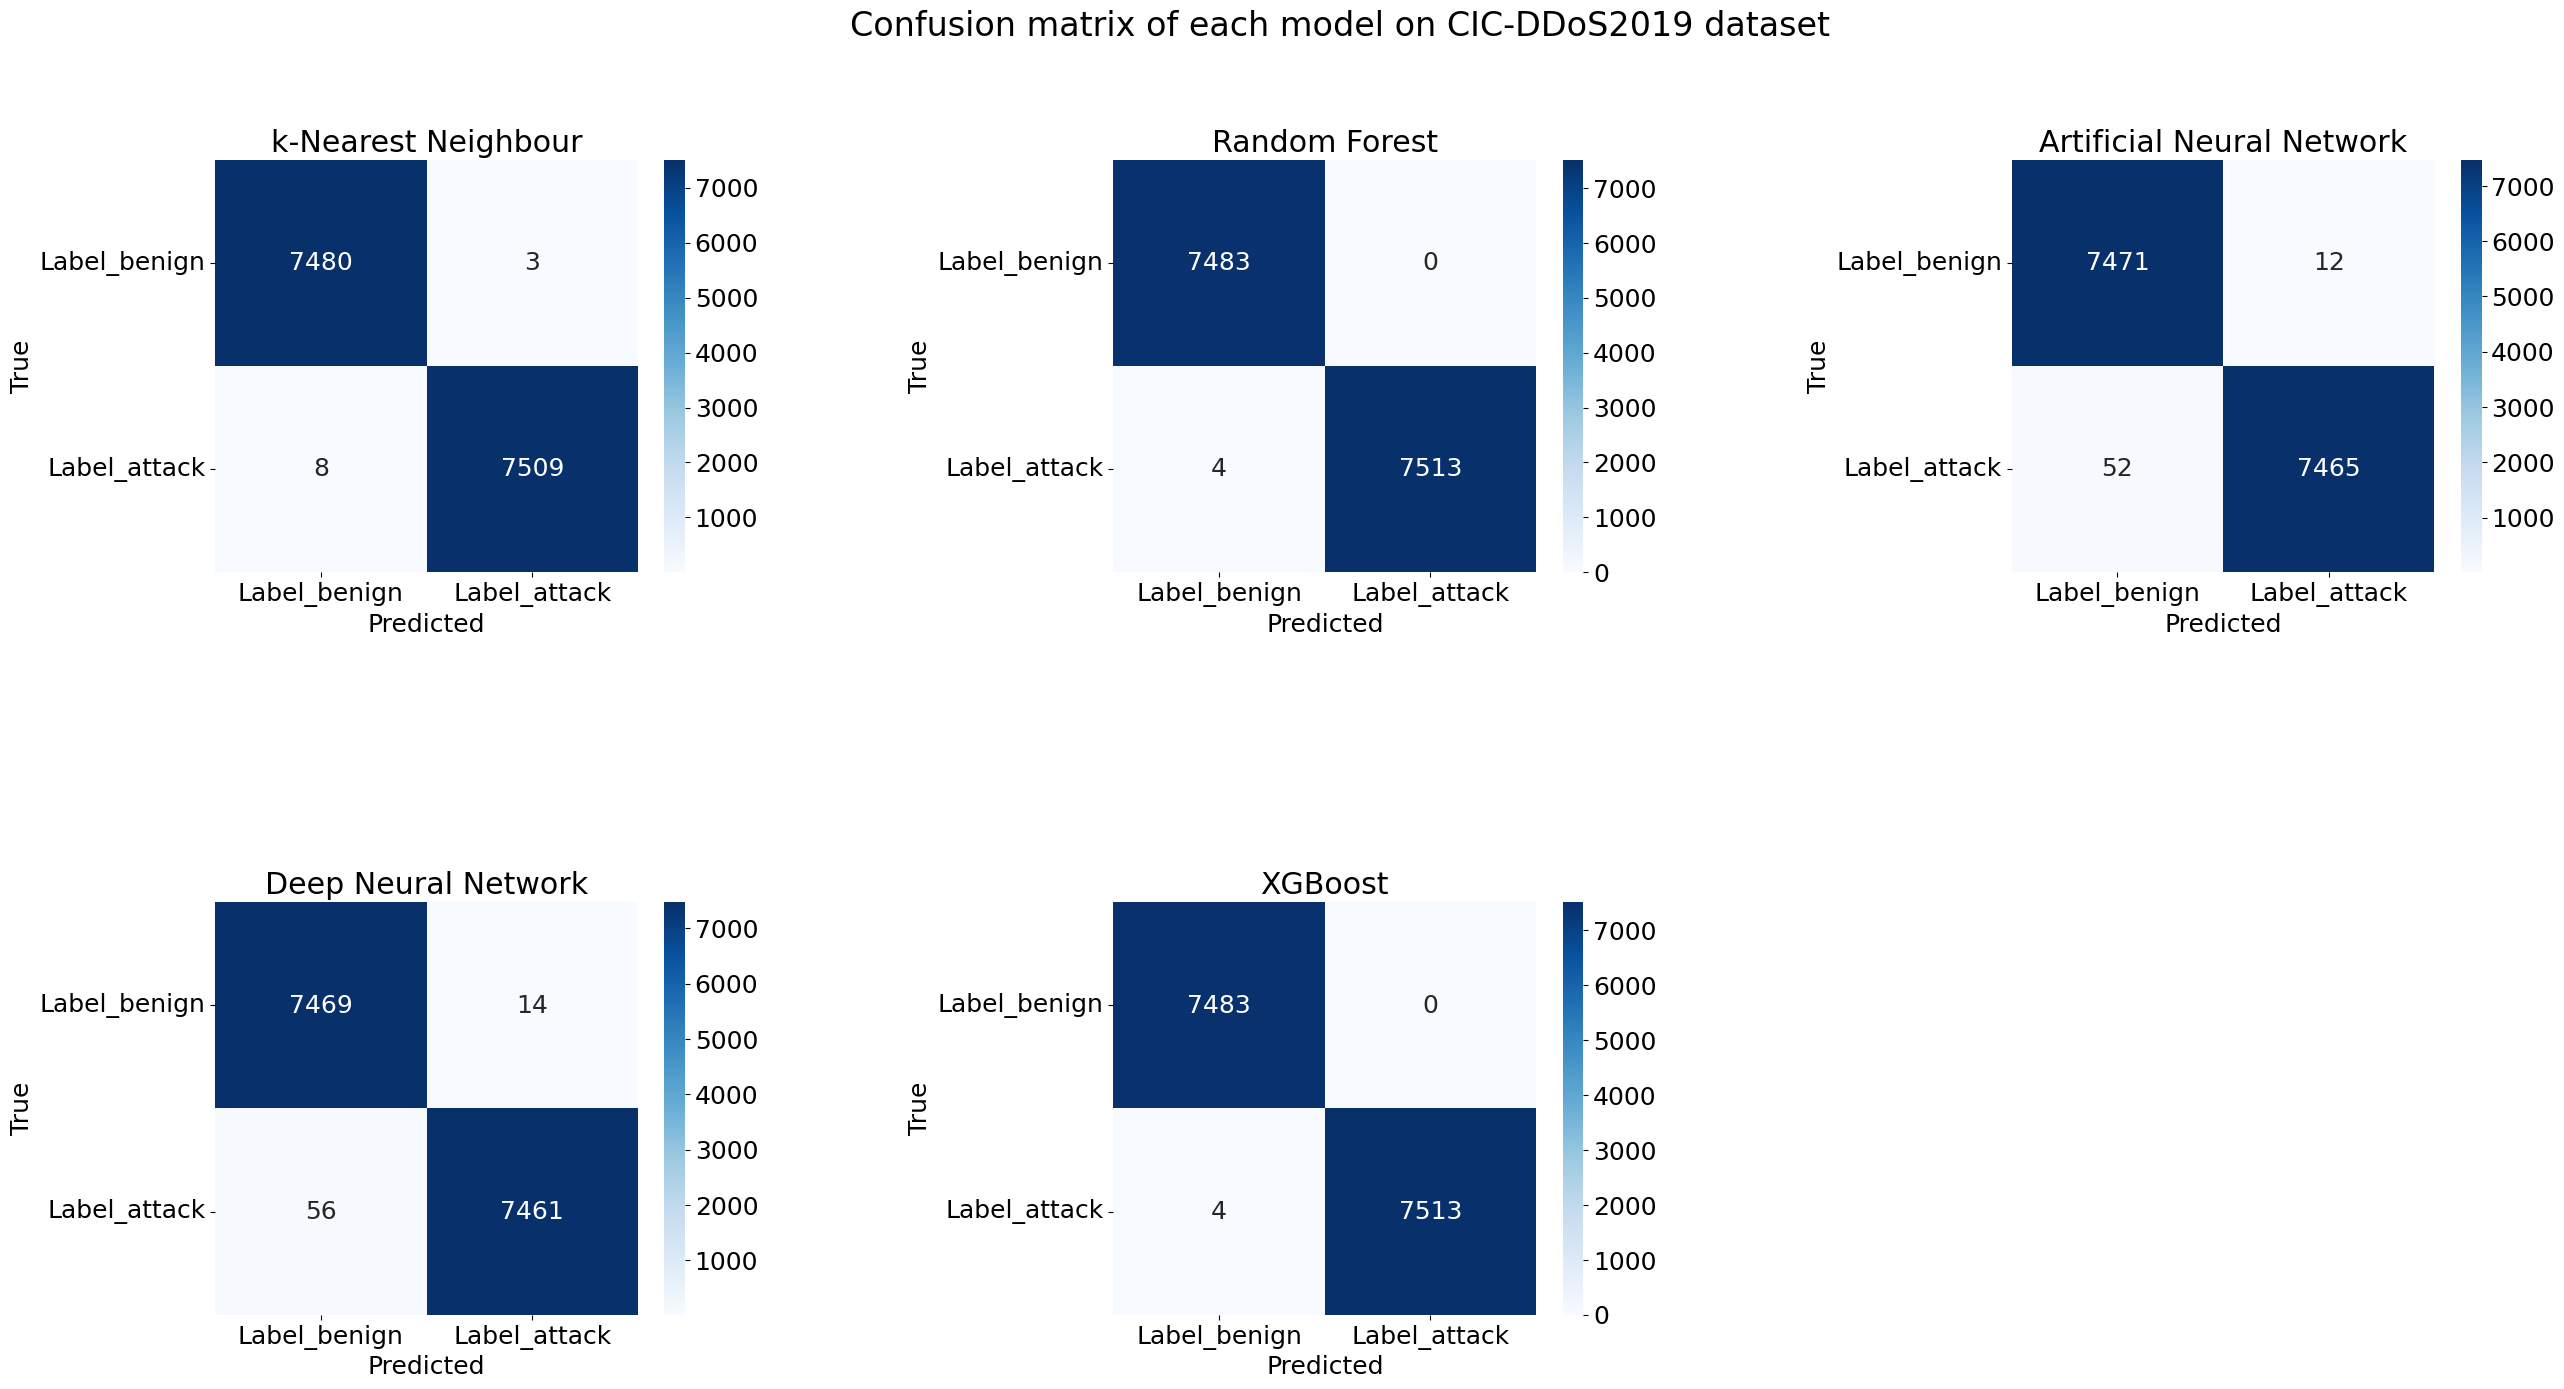

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})

# Calculate the number of models and layout dimensions
num_models = len(models)
num_rows = 2
num_cols = int(np.ceil(num_models / num_rows))

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 15))
flatten_axes = axes.flatten()  # Flatten the axes array for easier indexing

# Dictionaries to store the reports, accuracy, and F1 score
classification_reports = {}
accuracy_scores = {}
f1_scores = {}

# Iterate over the models
for i, (model_name, model) in enumerate(models.items()):
    # Fit the model on the training data
    model.fit(DDoS2019_train_X_scaled, DDoS2019_binary_train_y)

    # Generate predictions for the test set
    y_pred = model.predict(DDoS2019_test_X_scaled)

    # Extract the target labels with "Label_" prefix
    target_columns = [col for col in DDoS2019_binary_test_y.columns if col.startswith("Label_")]
    target_names = [col.split("Label_")[1] for col in target_columns]

    # Compute the classification report
    report = classification_report(DDoS2019_binary_test_y[target_columns], y_pred, digits=4, target_names=target_names, output_dict=True)

    # Save the classification report
    classification_reports[model_name] = report

    # Print the classification report
    print(f"{'-' * 20} {model_name} {'-' * 20}")
    print(classification_report(DDoS2019_binary_test_y[target_columns], y_pred, digits=4, target_names=target_names))

    # Compute the accuracy
    accuracy = accuracy_score(DDoS2019_binary_test_y[target_columns], y_pred)
    accuracy_scores[model_name] = accuracy
    print(f"Accuracy: {accuracy}")
    print()

    # Compute the F1 score
    f1 = f1_score(DDoS2019_binary_test_y[target_columns], y_pred, average='weighted')
    f1_scores[model_name] = f1

    # Compute the confusion matrix
    cm = confusion_matrix(DDoS2019_binary_test_y[target_columns].values.argmax(axis=1), y_pred.argmax(axis=1))

    # Calculate the row and column index in the subplots grid
    row = i // num_cols
    col = i % num_cols

    # Create a figure and axis
    ax = flatten_axes[i]

    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

    # Set labels, title, and ticks
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name}')
    ax.xaxis.set_ticklabels(target_columns, rotation=0)
    ax.yaxis.set_ticklabels(target_columns, rotation=0)

# Remove empty subplots
for i in range(num_models, num_rows * num_cols):
    fig.delaxes(flatten_axes[i])

# Adjust the layout spacing
fig.subplots_adjust(hspace=0.8, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CIC-DDoS2019 dataset', fontsize=24)

# Save accuracy and F1 score as pickle file
with open('metrics.pkl', 'wb') as f:
    pickle.dump({'accuracy': accuracy_scores, 'f1_score': f1_scores}, f)

# Show the plot
plt.show()


In [36]:
directory = '/content/drive/MyDrive/Binary_Win_Latest/Dataset/Metrics'
pickle_file_path = f"{directory}/metrics_binary.pkl"

os.makedirs(directory, exist_ok=True)

with open(pickle_file_path, 'wb') as f:
    pickle.dump({'accuracy': accuracy_scores, 'f1_score': f1_scores}, f)
